In [1]:
from utils_all import *
from utils_data import *
from transformation_utils import *
from sklearn.model_selection import train_test_split

In [2]:
import math
import torch
from functools import partial
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import trunc_normal_

/home/mila/e/eya.cherif/pytorch_ts/lib/python3.8/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
import torch
import torch.nn as nn
from typing import Callable, Optional, Union
from enum import Enum
from itertools import repeat
import collections.abc
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

import time
import pandas as pd

In [4]:
import warnings
warnings.filterwarnings('ignore')  # ignore warnings, like ZeroDivision

In [5]:
print(torch.cuda.is_available())

print(torch.__version__)  # PyTorch version
print(torch.version.cuda)  # CUDA version
print(torch.backends.cudnn.version())  # cuDNN version

True
1.8.1+cu111
11.1
8005


In [6]:
# Check if GPU is available
if torch.cuda.is_available():
    # Set the device to GPU
    device = torch.device("cuda")
    print("GPU is available. Using GPU for computation.")
else:
    # If GPU is not available, fall back to CPU
    device = torch.device("cpu")
    print("GPU is not available. Using CPU for computation.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #device = 'cuda'#'cuda:0' cpu
# gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device

GPU is available. Using GPU for computation.


device(type='cuda')

In [7]:
SEED = 155

# Python random seed
random.seed(SEED)

# Numpy seed
np.random.seed(SEED)

# PyTorch seed
torch.manual_seed(SEED)

# If using CUDA
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using multi-GPU

# Ensuring deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
# def cosine_similarity_loss(output, target):
#     return (1 - nn.functional.cosine_similarity(output, target, dim=-1)).mean()

In [9]:
# iterations_per_epoch = len(train_loader)
start_lr= 5e-4
weight_decay = 1e-4

n_epochs = 500
start_epoch = 1

mask_ratio = 0.75
batch_size = 256

In [10]:
########## Option 1 #########>>> fixed pos_emb

import torch
import torch.nn as nn
from typing import Callable, Optional, Union
from enum import Enum
from itertools import repeat
import collections.abc
import numpy as np



class Format(str, Enum):
    NCHW = 'NCHW'
    NHWC = 'NHWC'
    NCL = 'NCL'
    NLC = 'NLC'

def _ntuple(n):
    def parse(x):
        if isinstance(x, collections.abc.Iterable) and not isinstance(x, str):
            return tuple(x)
        return tuple(repeat(x, n))
    return parse

to_2tuple = _ntuple(2)
to_1tuple = _ntuple(1)

FormatT = Union[str, Format]

def get_spatial_dim(fmt: FormatT):
    fmt = Format(fmt)
    if fmt is Format.NLC:
        dim = (1,)
    elif fmt is Format.NCL:
        dim = (2,)
    elif fmt is Format.NHWC:
        dim = (1, 2)
    else:
        dim = (2, 3)
    return dim


def get_channel_dim(fmt: FormatT):
    fmt = Format(fmt)
    if fmt is Format.NHWC:
        dim = 3
    elif fmt is Format.NLC:
        dim = 2
    else:
        dim = 1
    return dim


def nchw_to(x: torch.Tensor, fmt: Format):
    if fmt == Format.NHWC:
        x = x.permute(0, 2, 3, 1)
    elif fmt == Format.NLC:
        x = x.flatten(2).transpose(1, 2)
    elif fmt == Format.NCL:
        x = x.flatten(2)
    return x


def nhwc_to(x: torch.Tensor, fmt: Format):
    if fmt == Format.NCHW:
        x = x.permute(0, 3, 1, 2)
    elif fmt == Format.NLC:
        x = x.flatten(1, 2)
    elif fmt == Format.NCL:
        x = x.flatten(1, 2).transpose(1, 2)
    return x

try:
    from torch import _assert
except ImportError:
    def _assert(condition: bool, message: str):
        assert condition, message

       
class SeqEmbed(nn.Module):
    ### Modified"!!
    """ Spectrum (batch_size x n_bands) to Sequence Embedding (batch_size x n_sequences x dim_embedding)
    """
    def __init__(
            self,
            n_bands: int = 1720,
            seq_size: int = 20,
            in_chans: int = 1,
            embed_dim: int = 128,
            norm_layer: Optional[Callable] = None,
            flatten: bool = False,
            output_fmt: Optional[str] = None,
            bias: bool = True,
            strict_sp_size: bool = True,
    ):
        super().__init__()
        self.seq_size = seq_size
        self.n_bands = n_bands
        self.num_sequences = self.n_bands // self.seq_size

        self.flatten = flatten
        self.strict_sp_size = strict_sp_size

        self.proj = nn.Conv1d(seq_size, embed_dim, kernel_size=5, stride=1, padding=2, bias=bias)
        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()
        
        # Optionally freeze the parameters here
        for param in self.proj.parameters():
            param.requires_grad = False

    def forward(self, x):
        B, n_bands = x.shape
        
        if self.strict_sp_size:
            _assert(n_bands == self.n_bands, f"Spectral dimension ({n_bands}) doesn't match model ({self.n_bands}).")
        else:
            _assert(
                n_bands % self.seq_size == 0,
                f"Spectral dimension ({n_bands}) should be divisible by sequence size ({self.seq_size})."
            )
        # Create patches: (B, num_patches, patch_size)
        x = x.view(B, self.num_sequences, self.seq_size).transpose(1, 2)
        
        x = self.proj(x).transpose(1, 2)
        x = self.norm(x)
        return x

class Attention(nn.Module):
    def __init__(
            self,
            dim,
            num_heads=8,
            qkv_bias=False,
            qk_norm=False,
            qk_scale=None,
            attn_drop=0.,
            proj_drop=0.,
            norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.fused_attn = False

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn:
            x = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_drop.p,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)
            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    """ MLP as used in Vision Transformer, MLP-Mixer and related networks
    """
    def __init__(
            self,
            in_features,
            hidden_features=None,
            out_features=None,
            act_layer=nn.GELU,
            norm_layer=None,
            bias=True,
            drop=0.,
            use_conv=False,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        bias = to_2tuple(bias)
        drop_probs = to_2tuple(drop)
        linear_layer = partial(nn.Conv2d, kernel_size=1) if use_conv else nn.Linear

        self.fc1 = linear_layer(in_features, hidden_features, bias=bias[0])
        self.act = act_layer()
        self.drop1 = nn.Dropout(drop_probs[0])
        self.norm = norm_layer(hidden_features) if norm_layer is not None else nn.Identity()
        self.fc2 = linear_layer(hidden_features, out_features, bias=bias[1])
        self.drop2 = nn.Dropout(drop_probs[1])

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.norm(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

def drop_path(x, drop_prob: float = 0., training: bool = False, scale_by_keep: bool = True):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.

    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = x.new_empty(shape).bernoulli_(keep_prob)
    if keep_prob > 0.0 and scale_by_keep:
        random_tensor.div_(keep_prob)
    return x * random_tensor


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """
    def __init__(self, drop_prob: float = 0., scale_by_keep: bool = True):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob
        self.scale_by_keep = scale_by_keep

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training, self.scale_by_keep)

    def extra_repr(self):
        return f'drop_prob={round(self.drop_prob,3):0.3f}'


class LayerScale(nn.Module):
    def __init__(self, dim, init_values=1e-5, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.gamma = nn.Parameter(init_values * torch.ones(dim))

    def forward(self, x):
        return x.mul_(self.gamma) if self.inplace else x * self.gamma

class Block(nn.Module):

    def __init__(
            self,
            dim,
            num_heads,
            mlp_ratio=4.,
            qkv_bias=False,
            qk_norm=False,
            qk_scale=None,
            proj_drop=0.,
            attn_drop=0.,
            init_values=None,
            drop_path=0.,
            act_layer=nn.GELU,
            norm_layer=nn.LayerNorm,
            mlp_layer=Mlp,
    ):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_norm=qk_norm,
            qk_scale=None,
            attn_drop=attn_drop,
            proj_drop=proj_drop,
            norm_layer=norm_layer,
        )
        self.ls1 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        self.drop_path1 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

        self.norm2 = norm_layer(dim)
        self.mlp = mlp_layer(
            in_features=dim,
            hidden_features=int(dim * mlp_ratio),
            act_layer=act_layer,
            drop=proj_drop,
        )
        self.ls2 = LayerScale(dim, init_values=init_values) if init_values else nn.Identity()
        self.drop_path2 = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.ls1(self.attn(self.norm1(x))))
        x = x + self.drop_path2(self.ls2(self.mlp(self.norm2(x))))
        return x

def get_1d_sincos_pos_embed(embed_dim, grid_size, cls_token=True):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    grid = np.arange(grid_size, dtype=np.float32)
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    out = np.einsum('m,d->md', grid, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)

    if cls_token:
        emb = np.concatenate([np.zeros([1, embed_dim]), emb], axis=0)
    return emb

In [17]:
import sys
import os

from MAE.utils_mae import *
from utils_all import *

import torch
import torch.nn as nn
from typing import Callable, Optional, Union
from enum import Enum
from itertools import repeat
import collections.abc
import numpy as np

### the code was adapted from : https://github.com/Romain3Ch216/tlse-experiments/tree/main

class MaskedAutoencoder(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, n_bands=310, seq_size=5, in_chans=1,
                 embed_dim=32, depth=4, num_heads=4,
                 decoder_embed_dim=32, decoder_depth=4, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, cls_token=True):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.seq_embed = SeqEmbed(n_bands, seq_size, in_chans, embed_dim)
        num_sequences = self.seq_embed.num_sequences

        if cls_token:
            self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
            self.is_cls_token = True
        else:
            self.is_cls_token = False

        self.pos_embed = nn.Parameter(torch.zeros(1, num_sequences + np.sum(self.is_cls_token), embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------
        n_params = 0
        for param in self.parameters():
            n_params += param.shape.numel()
        print(f'Encoder has {n_params} parameters.')
        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_sequences + np.sum(self.is_cls_token), decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, seq_size * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.initialize_weights()

        n_params = -n_params
        for param in self.parameters():
            n_params += param.shape.numel()
        print(f'Decoder has {n_params} parameters.')


    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_1d_sincos_pos_embed(self.pos_embed.shape[-1], self.seq_embed.num_sequences, cls_token=self.is_cls_token)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_1d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], self.seq_embed.num_sequences, cls_token=self.is_cls_token)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.seq_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        if self.is_cls_token:
            torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def sequencify(self, spectra):
        """
        spectra: (batch_size, n_bands)
        x: (batch_size, num_sequences, seq_size)
        """
        seq_size = self.seq_embed.seq_size
        assert spectra.shape[1] % seq_size == 0

        num_sequences = spectra.shape[1] // seq_size
        x = spectra.reshape(shape=(spectra.shape[0], num_sequences, seq_size))
        return x

    def unsequencify(self, x):
        """
        x: (batch_size, num_sequences, seq_size)
        spectra: (batch_size, n_bands)
        """
        spectra = x.reshape(shape=(x.shape[0], -1))
        return spectra
    
    def half_masking(self, x, last_token=None):
        """
        Perform per-sample half masking: 
        the first half of the patches is masked (all True), 
        and the second half is unmasked (all False).
    
        Args:
            x: [N, L, D] tensor, where:
                N = batch size,
                L = sequence length (number of patches),
                D = embedding dimension of each patch.
    
        Returns:
            x_masked: [N, L/2, D] masked tensor with only the unmasked patches.
            mask: [N, L] binary mask (0 = keep, 1 = mask).
            ids_restore: [N, L] tensor to restore the original sequence order.
        """
        N, L, D = x.shape  # batch, length, dim
        
        if(last_token is None):
            # Calculate half-length of the sequence
            first_half_length = L // 2
        else:
            first_half_length = last_token
    
        # Generate indices for shuffling
        ids = torch.arange(L, device=x.device).unsqueeze(0).repeat(N, 1)
        
        # Define the first half and second half indices
        ids_keep = ids[:, :first_half_length]  # Second half (unmasked) ## mask second half
        ids_mask = ids[:, first_half_length:]  # First half (masked)
    
        # Combine the indices to form a restore order
        # ids_restore = torch.cat([ids_mask, ids_keep], dim=1)
        ids_restore = torch.cat([ids_keep, ids_mask], dim=1)
    
        # Masked input: keep only the second half
        x_masked = x[:, :first_half_length, :] #torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
    
        # Binary mask: 1 for masked patches, 0 for unmasked patches
        mask = torch.ones((N, L), device=x.device)
        mask[:, :first_half_length] = 0  # Unmasked first half    
        return x_masked, mask, ids_restore
        
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore


    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.seq_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, np.sum(self.is_cls_token):, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        if self.is_cls_token:
            cls_token = self.cls_token + self.pos_embed[:, :1, :]
            cls_tokens = cls_token.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, np.sum(self.is_cls_token):, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        if self.is_cls_token:
            x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token
        else:
            x = x_

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        if self.is_cls_token:
            x = x[:, 1:, :]

        return x

    def forward_loss(self, spectra, pred, mask):
        """
        spectra: [batch_size, n_bands]
        pred: [batch_size, num_sequences, seq_size]
        mask: [batch_size, num_sequences], 0 is keep, 1 is remove,
        """
        target = self.sequencify(spectra)
        loss_mse = torch.abs(pred - target)** 2
        loss_mse = loss_mse.mean(dim=-1)  # [N, L], mean loss per patch
        
        cosine_loss = CosineSimilarityLoss()
        # Compute cosine similarity loss for masked sequences
        # cosine_loss_ = 1-cosine_loss(pred, target)
        cosine_loss_ = cosine_loss(pred, target)

        # Weighted sum of cosine and MSE losses
        w_loss = 0.1
        # loss = w_loss * cosine_loss_ + (1-w_loss) * loss_mse
        loss = w_loss * cosine_loss_ + loss_mse
        
        if mask.sum() > 0:
            loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        else:
            loss = loss.mean()
        return loss


    def latent(self, spectra):
        latent, _, _ = self.forward_encoder(spectra, mask_ratio=0)
        if self.is_cls_token:
            latent = latent[:, 0, :]
        else:
            latent = torch.mean(latent[:, 1:, :], dim=1)
        return latent

    def forward(self, spectra, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(spectra, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)
        loss = self.forward_loss(spectra, pred, mask)
        return loss, pred, mask, latent

In [12]:
import glob
import os
# directory_path = '/home/mila/e/eya.cherif/scratch/Datasets/csv_files'
directory_path = '/home/mila/e/eya.cherif/scratch/Datasets/csv_files_Ecosis'

file_paths = glob.glob(os.path.join(directory_path, "*.csv"))

In [13]:
percentage_tr = 1
scale = False

file_paths = file_paths[:int(percentage_tr*len(file_paths))]

dataset = MultiFileAugmentedCSVDataset(file_paths[:-1], chunk_size=1000, augmentation=True, aug_prob=0.6, scale=scale)
train_loader = DataLoader(dataset, batch_size=256, 
                        shuffle=True
                       )

dataset = MultiFileAugmentedCSVDataset(file_paths[-1:], chunk_size=1000, augmentation=False, aug_prob=0.5, scale=scale)
valid_loader = DataLoader(dataset, batch_size=256, 
                        shuffle=False
                       )

In [14]:
def train_step(batch):
    # prepare model for training
    model.train()
    optimizer.zero_grad()
    
    x = batch
    x = x.to(device).view(x.shape[0], x.shape[-1])
    
    loss, pred, mask, z = model(x) #, mask_ratio= mask_ratio
    
    loss.backward()
    optimizer.step()
    return z.detach().cpu(), loss.item()
    # return z.detach().cpu(), y.cpu(), loss.item()

def val_step(batch):
    # set model to evaluation mode
    model.eval()
    
    x = batch
    x = x.to(device).view(x.shape[0], x.shape[-1])
    
    with torch.no_grad():
      loss, pred, mask, z = model(x) #, mask_ratio=mask_ratio
    
    return z.cpu(), loss.item()

In [18]:
model = MaskedAutoencoder(n_bands=1720, seq_size=20, in_chans=1,
                 embed_dim=128, depth=6, num_heads=4,
                 decoder_embed_dim=128, decoder_depth=6, decoder_num_heads=4,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, cls_token=False) ## cls_token >> add class token NO NEED!!


optimizer = torch.optim.AdamW(model.parameters(), lr=start_lr, weight_decay=weight_decay)

# **📌 Define Warmup Scheduler**
warmup_epochs = int(0.1 * n_epochs)  # 10% of total epochs
warmup_scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer, 
    lambda epoch: min(1.0, epoch / warmup_epochs)  # Linear warmup
)

# **📉 Define Cosine Annealing Scheduler**
decay_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=n_epochs - warmup_epochs, eta_min=1e-6  # Min LR for stability
)

# Initialize an attribute to track scheduler mode
scheduler_mode = "warmup"  # Start with warmup

Encoder has 1213824 parameters.
Decoder has 1220116 parameters.


Training epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.10it/s]


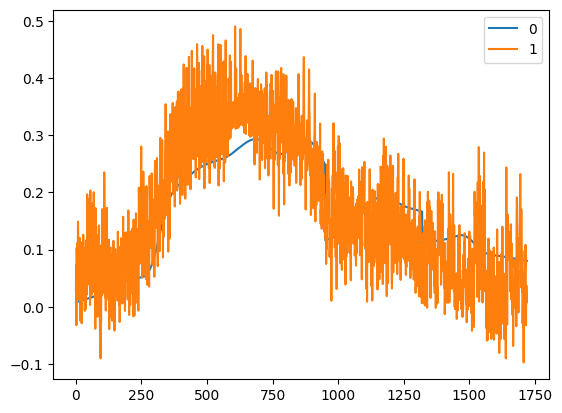

Training Loss: 0.095882 	 Validation Loss: 0.013873


Training epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.24it/s]


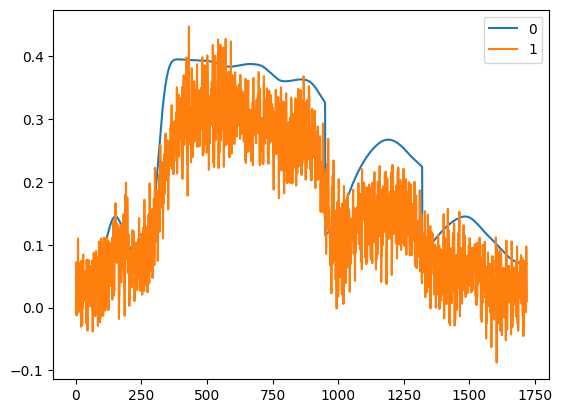

Training Loss: 0.012506 	 Validation Loss: 0.010761


Training epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:13<00:00,  7.04it/s]


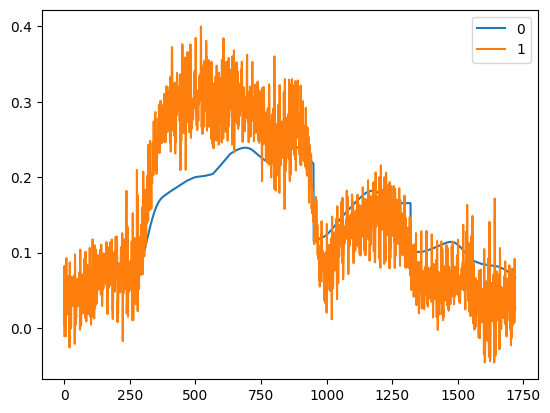

Training Loss: 0.010499 	 Validation Loss: 0.009365


Training epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.34it/s]


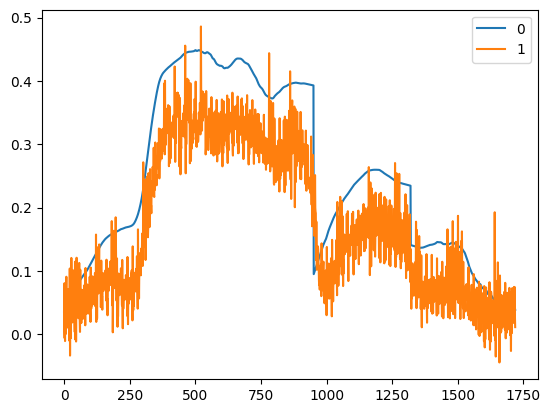

Training Loss: 0.009382 	 Validation Loss: 0.008081


Training epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:13<00:00,  6.99it/s]


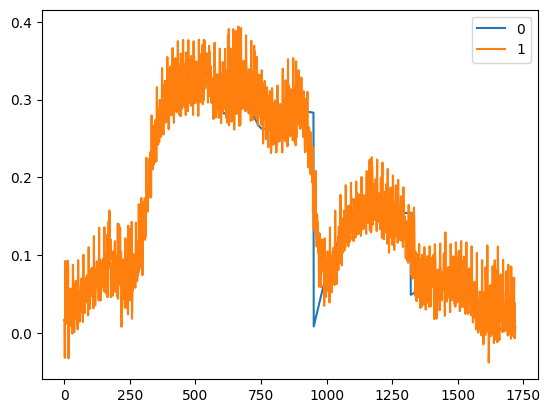

Training Loss: 0.007442 	 Validation Loss: 0.005580


Training epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.26it/s]


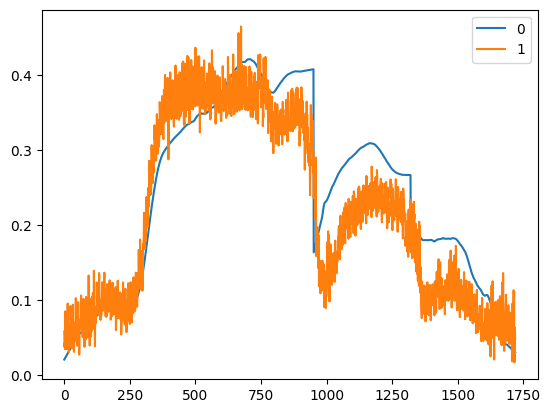

Training Loss: 0.005219 	 Validation Loss: 0.004149


Training epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.26it/s]


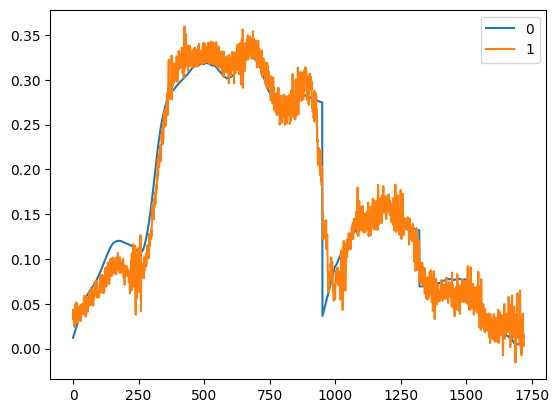

Training Loss: 0.003848 	 Validation Loss: 0.003285


Training epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:13<00:00,  7.06it/s]


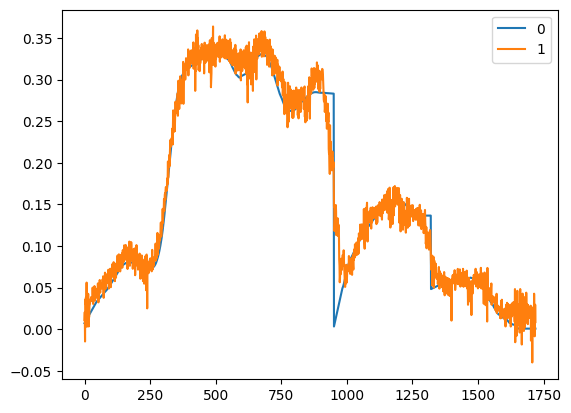

Training Loss: 0.003045 	 Validation Loss: 0.002546


Training epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:12<00:00,  7.17it/s]


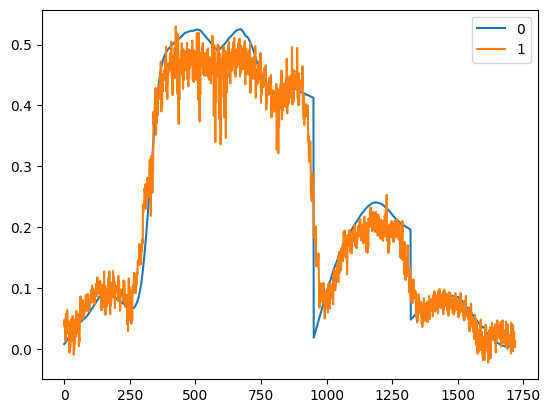

Training Loss: 0.002293 	 Validation Loss: 0.001716


Training epoch 10:  60%|██████████████████████████████████████████████████████████████████████████▏                                                 | 55/92 [00:08<00:05,  6.33it/s]


KeyboardInterrupt: 

In [19]:
########## Training ########
train_loss_list, valid_loss_list = [], []

model.to(device)

curr = time.process_time()

for e in range(start_epoch, n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    for images in tqdm(train_loader,
                    total=len(train_loader),
                    desc=f'Training epoch {e}'):
        # # move to gpu if available
        images = images.view(images.shape[0], images.shape[-1])[:,:-1].to(device)
        
        
        z, loss = train_step(images)
        # track loss
        train_loss += loss
    
    # validate model
    for images in valid_loader:
        # move to gpu if available
        images = images.view(images.shape[0], images.shape[-1])[:,:-1].to(device)

        z, loss_val = val_step(images)
        
        valid_loss += loss_val
    
    # get average loss values
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    
    # # **📌 Step the correct scheduler**
    # if e < warmup_epochs:
    #     warmup_scheduler.step()  # Step warmup
    # else:
    #     if scheduler_mode == "warmup":  
    #         print(f"🔥 Switching from Warmup to Cosine Annealing at epoch {e}")
    #         scheduler_mode = "cosine"  # Change mode
    #     decay_scheduler.step()  # Step cosine annealing

    images = next(iter(valid_loader))
        
    x = images
    x = x.to(device).view(x.shape[0], x.shape[-1])[:,:-1]
    # x = x.view(x.shape[0], x.shape[-1])[:,:500].to(device) ####half_range
    
    with torch.no_grad():
        loss, pred, mask, z = model(x) #, mask_ratio=0.75
    
    ind = 100
    
    spectra = pred.cpu().reshape(shape=(images.shape[0], -1))
    pd.DataFrame([np.array(x[ind].cpu()),np.array(spectra[ind].cpu())]).T.plot()
    plt.show()
    
    # output training statistics for epoch
    print('Training Loss: {:.6f} \t Validation Loss: {:.6f}'
                .format( train_loss, valid_loss))

end = time.process_time()- curr
print('the training process took {}s >> {}h'.format(end, end/3600))

In [ ]:
0.074921 0.015003
0.022749 0.012889

[1, 0.1, 0.01]

In [1]:
#### Module ###
from utils_data import *
from transformation_utils import *
from utils_all import *

from MAE.utils_mae import *
from MAE.trainer_mae import *
from MAE.MAE_1D import *
from MAE.multi_trait import *
from MAE.trainer_trait import *


import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.optim import lr_scheduler

import wandb 
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import glob


device = torch.device(
            'cuda' if torch.cuda.is_available() else 'cpu')

from datetime import datetime

# Get the current date and time
current_datetime = datetime.now()

# Format the date and time in YYMMDD_HHMM format
formatted_datetime = current_datetime.strftime("%y%m%d_%H%M")


### fix:
path_save = '/home/mila/e/eya.cherif/scratch/mae/'
project = 'MAE_wandb_test'
seed = 155 #random.randint(0, 500)

ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]

directory_path = '/home/mila/e/eya.cherif/scratch/Datasets/csv_files'
# directory_path = '/home/mila/e/eya.cherif/scratch/Datasets/csv_files_Ecosis'
file_paths = glob.glob(os.path.join(directory_path, "*.csv"))

start_lr= 5e-4
weight_decay = 1e-4

n_epochs = 500
start_epoch = 1

mask_ratio = 0.75
batch_size = 256

w_loss = 1

# percentage_tr = 1
for percentage_tr in [1]: #1,0.8, 0.6, 0.4, 0.2
    
    #####
    settings_dict_mae = {
        'seed' : seed,
        'epochs': n_epochs,
        'file_paths' : file_paths,
        'batch_size': batch_size,
        'learning_rate': start_lr,
        'weight_decay': weight_decay,
        'w_loss': w_loss,

        'mask_ratio': mask_ratio,
        'n_bands': 1720,
        'seq_size': 20,
        'in_chans': 1,
        'embed_dim': 128,
        'depth': 6, #4
        'num_heads': 4,
        'decoder_embed_dim': 128,
        'decoder_depth': 6, #4
        'decoder_num_heads': 4,
        'mlp_ratio': 4.0,
        'norm_layer': nn.LayerNorm,
        'cls_token': False,
        'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    
        # 'checkpoint_dir': checkpoint_dir_mae,
        'early_stop': True,
        'patience': 10,
    }
    
    sets = Settings()
    sets.update_from_dict(settings_dict_mae)
    
    test = Trainer(sets)
    
    # seed_all(seed=seed) ###155
    # test.dataset_setup()
    
    # # dataset = MultiFileAugmentedCSVDataset(file_paths[:-1], chunk_size=1000, augmentation=True, aug_prob=0.6, scale=False)
    # # test.train_loader = DataLoader(dataset, batch_size=256, 
    # #                         shuffle=True
    # #                        )
    # # dataset = MultiFileAugmentedCSVDataset(file_paths[-1:], chunk_size=1000, augmentation=False, aug_prob=0.5, scale=False)
    # # test.valid_loader = DataLoader(dataset, batch_size=256, 
    # #                         shuffle=False
    # #                        )
    
    # test.model_setup()
    
    # for param in test.model.seq_embed.proj.parameters():
    #     param.requires_grad = False
        
    # test.prepare_optimizers(num_epochs=test.settings.epochs)
    # test.gpu_mode()
    # test.train_mode()
    
    # # test.early_stopping_setup()
    # test.training_loop(epoch_start=1, num_epochs = test.settings.epochs)


    test.train()

Encoder has 1213824 parameters.
Decoder has 1220116 parameters.


TypeError: expected str, bytes or os.PathLike object, not NoneType

In [6]:
test.model.seq_embed.proj

Conv1d(20, 128, kernel_size=(5,), stride=(1,), padding=(2,))

In [1]:
# import torch
# import torch.nn as nn


# def half_latent(x, model):
#     # embed patches
#     x = model.seq_embed(x)
    
#     # add pos embed w/o cls token
#     x = x + model.pos_embed[:, np.sum(model.is_cls_token):, :]
    
#     x, mask, ids_restore = model.half_masking(x)
    
#     # apply Transformer blocks
#     for blk in model.blocks:
#         x = blk(x)
#     z = model.norm(x)
#     return z


# # seq_size = (1720 // test.model.seq_embed.seq_size)  # Number of sequences in MAE (1720 // 10)

# class LatentRegressionModel(nn.Module):
#     def __init__(self, pretrained_encoder, latent_dim, output_dim, input_dim = 1720, hidden_dims=None, aggregation="none", normalize_latent=False, freeze_encoder=True):
#         """
#         Args:
#             pretrained_encoder (nn.Module): Pretrained MAE encoder.
#             latent_dim (int): Dimension of the latent vector.
#             output_dim (int): Dimension of the output (e.g., number of regression targets).
#             hidden_dims (list of int): Sizes of hidden layers for dense regression head. If None, use a single layer.
#             aggregation (str): Aggregation strategy ('none', 'mean', 'custom').
#             normalize_latent (bool): Whether to apply LayerNorm to the latent space.
#         """
#         super().__init__()
#         self.encoder = pretrained_encoder
#         self.latent_dim = latent_dim
#         self.output_dim = output_dim
#         self.aggregation = aggregation
#         self.normalize_latent = normalize_latent

#         # Normalization layer for latent features (optional)
#         if self.normalize_latent:
#             self.normalization = nn.LayerNorm(self.latent_dim)
#         else:
#             self.normalization = None

#         # Create the regression head
#         seq_size = (input_dim // pretrained_encoder.seq_embed.seq_size)
        
#         input_dim = {
#             "none": seq_size * latent_dim,
#             "mean": latent_dim,
#             "custom": 3 * latent_dim
#         }.get(aggregation, seq_size * latent_dim)

#         self.regression_head = self._build_regression_head(input_dim, hidden_dims, output_dim)

#     def _build_regression_head(self, input_dim, hidden_dims, output_dim):
#         """Constructs a regression head with optional dense layers."""
#         layers = []
#         if hidden_dims is not None:
#             for hidden_dim in hidden_dims:
#                 layers.append(nn.Linear(input_dim, hidden_dim))
#                 layers.append(nn.ReLU())
#                 layers.append(nn.LayerNorm(hidden_dim))
#                 input_dim = hidden_dim
#         layers.append(nn.Linear(input_dim, output_dim))  # Final output layer
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         # Extract latent representations
#         # latent, _, _ = self.encoder(x, mask_ratio=0)  # No masking during regression
#         latent, _, _ = self.encoder.forward_encoder(x, mask_ratio=0)  # No masking during regression
#         # latent = half_latent(x, self.encoder)
        
#         # self.encoder.mask_ratio = 0
#         # latent, _, _ = self.encoder.forward_encoder(x)  # No masking during regression
        
#         # Normalize latent representations (if enabled)
#         if self.normalize_latent:
#             latent = self.normalization(latent)

#         # Apply aggregation strategy
#         if self.aggregation == "none":  # Use full sequence
#             latent = latent.flatten(start_dim=1)
#         elif self.aggregation == "mean":  # Mean pooling
#             latent = latent.mean(dim=1)
#         elif self.aggregation == "custom":  # Custom (e.g., VIS/NIR/SWIR concatenation)
#             # #10
#             # vis = torch.mean(latent[:, :20, :], dim=1)
#             # nir = torch.mean(latent[:, 20:97, :], dim=1)
#             # swir = torch.mean(latent[:, 97:, :], dim=1)

#             ####20
#             vis = torch.mean(latent[:, :10, :], dim=1)
#             nir = torch.mean(latent[:, 10:48, :], dim=1)
#             swir = torch.mean(latent[:, 48:, :], dim=1)
            
#             latent = torch.cat([vis, nir, swir], dim=1)
#             latent = latent.flatten(start_dim=1)

#         # Pass through regression head
#         return self.regression_head(latent)


In [2]:
# from utils_data import *
# from transformation_utils import *
# from utils_all import *

# from MAE.utils_mae import *
# from MAE.trainer_mae import *
# from MAE.MAE_1D import *
# from MAE.multi_trait import *
# from MAE.trainer_trait import *

# import gc

# def downstream(model_mae):
#     path_data_lb = '/home/mila/e/eya.cherif/Gan_project_test/49_all_lb_prosailPro.csv'
#     ls_tr = ["cab", "cw", "cm", "LAI", "cp", "cbc", "car", "anth"]
    
#     percentage_tr = 1
#     batch_size = 256
    
#     ########## Trait regression ####
#     ################ Data ###############
#     db_lb_all = pd.read_csv(path_data_lb, low_memory=False).drop(['Unnamed: 0'], axis=1)   
    
#     ### external
#     groups = db_lb_all.groupby('dataset')
    
#     val_ext_idx = list(groups.get_group(32).index)+list(groups.get_group(3).index)
#     samples_val_ext = db_lb_all.loc[val_ext_idx,:]
#     db_lb_all.drop(val_ext_idx, inplace=True)
    
#     X_labeled, y_labeled, _ = data_prep_db(db_lb_all, ls_tr, weight_sample=True)
#     metadata = db_lb_all.iloc[:, :8]  # The metadata (dataset of origin)
    
    
#     red_ed = X_labeled.loc[:,750]
#     red_end = X_labeled.loc[:,1300]
#     red1000_ = X_labeled.loc[:,1000]
    
#     idx = X_labeled[(red_end>red1000_) & (red_ed>red1000_)].index
    
#     if(len(idx)>0):
#         # X_labeled.loc[idx,:].T.plot(legend=False)
#         X_labeled.drop(idx, inplace=True)
#         y_labeled.drop(idx, inplace=True)
#         metadata.drop(idx, inplace=True)
    
    
#     # Split labeled data into train (80%), validation (10%), and test (10%)
#     fr_sup, val_x= train_test_split(X_labeled, test_size=0.2, stratify=metadata.dataset, random_state=300)
    
#     y_sup = y_labeled.loc[fr_sup.index,:]
#     meta_train = metadata.loc[fr_sup.index,:]
    
#     val_y = y_labeled.loc[val_x.index,:]
#     meta_val = metadata.loc[val_x.index,:]
    
#     if(percentage_tr<1):
#         fr_sup, _= train_test_split(fr_sup, test_size=1-percentage_tr, stratify=meta_train.dataset, random_state=300)
        
#         y_sup = y_sup.loc[fr_sup.index,:]
#         meta_train = meta_train.loc[fr_sup.index,:]
    
#     # ########## Scaler ###
#     scaler_list = None
#     scaler_model = save_scaler(y_sup, standardize=True, scale=True)
    
#     #########
#     ###### Create the dataset
#     train_dataset = SpectraDataset(fr_sup, y_sup, meta_train, augmentation=True, aug_prob=0.6)
#     # Define DataLoader with the custom collate function for fair upsampling
#     train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
#     #####
#     test_dataset = SpectraDataset(X_train=val_x, y_train=val_y, meta_train=meta_val, augmentation=False)
#     # Create DataLoader for the test dataset
#     valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    
#     settings_dict = {
#             # 'epochs': 50,
#             'train_loader': train_dataset_loader,
#             'valid_loader': valid_loader,
#             'batch_size': batch_size,
#             'learning_rate': 1e-3,
#             'weight_decay': 1e-4,
#             'pretrained_model': model_mae, #model,
#             # 'freeze': False,
#             'early_stop': False,
#             'patience': 10,
#             'scaler_model': scaler_model,
#         }
    
#     sets = Settings_reg()
#     sets.update_from_dict(settings_dict)
    
#     test_reg = Trainer_MAE_Reg(sets)
#     test_reg.dataset_setup()
    
    
#     ############ Moel modif ####
#     pretrained_model = test.model 
#     # Example latent vectors (replace with actual latent extraction)
#     latent_dim = pretrained_model.blocks[3].mlp.fc2.out_features
    
    
#     # Instantiate the model
#     test_reg.model = LatentRegressionModel(
#         pretrained_encoder=pretrained_model,
#         latent_dim=latent_dim,
#         output_dim=len(ls_tr),
#         hidden_dims=None,  # None or hidden_dims Add dense layers
#         aggregation="mean",
#         normalize_latent=True,  # Enable latent normalization
#     )
    
#     ############ Training ############
#     # Clean up after training
#     gc.collect()
#     torch.cuda.empty_cache()
    
#     test_reg.transformation_setup()
#     test_reg.criterion_setup()
    
#     test_reg.prepare_optimizers()
#     test_reg.gpu_mode()
#     # test_reg.early_stopping_setup()
    
#     for param in test_reg.model.encoder.parameters(): #encoder
#         param.requires_grad = False
    
#     test_reg.train_loop(epoch_start=1, num_epochs=200)
    
#     ############ Validation #############
#     test_tr = ls_tr
#     outputs_val = []
#     lb_val = []
    
#     for labeled_examples, labels, ds in tqdm(valid_loader):
#         test_reg.model.eval()
        
#         with torch.no_grad():
#             labeled_examples = labeled_examples.to(device)[:,:-1]
#             labels = labels.to(device)
#             output_val = test_reg.model(labeled_examples.squeeze().float()) #[:,:-1]
            
#             if(scaler_list is not None):
#                 outputs_val.append(scaler_list.inverse_transform(output_val.cpu().numpy()))
#                 lb_val.append(scaler_list.inverse_transform(labels.cpu().numpy()))
            
#             if(test_reg.transformation_layer_inv is not None):  
#                 output_val = test_reg.transformation_layer_inv(output_val)
             
#             outputs_val.append(output_val.cpu().numpy())
#             lb_val.append(labels.cpu().numpy())
    
#     pred = pd.DataFrame(np.concatenate(outputs_val, axis=0), columns=test_tr)#.shape
#     obs_pf = pd.DataFrame(np.concatenate(lb_val, axis=0), columns=test_tr)
    
#     val_mertics = eval_metrics(obs_pf, pred)
#     return val_mertics.values[:,0], val_mertics.values[:,2]

In [1]:
from utils_data import *
from transformation_utils import *
from utils_all import *

from MAE.utils_mae import *
from MAE.trainer_mae import *
from MAE.MAE_1D import *
from MAE.multi_trait import *
from MAE.trainer_trait import *


import os
import glob
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import itertools


import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset, Sampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import wandb 
from tqdm import tqdm

from datetime import datetime

# Seed for reproducibility
SEED = 155
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define parameter grid
depth_values = [6] #[6, 8, 10]  # Change as needed
num_heads_values = [4, 8] #[[4, 8, 16]]  # Change as needed
param_grid = list(itertools.product(depth_values, num_heads_values))

# Initialize WandB project
project = "MAE_grid_search"
path_save = "/home/mila/e/eya.cherif/scratch/mae/"
batch_size = 128 #256
n_epochs = 500
lr = 5e-4
weight_decay = 1e-4
mask_ratio = 0.75
scale = False
augmentation = True

# Define dataset paths
# directory_path = "/home/mila/e/eya.cherif/scratch/Datasets/csv_files"
directory_path = '/home/mila/e/eya.cherif/scratch/Datasets/csv_files_Ecosis'
file_paths = glob.glob(os.path.join(directory_path, "*.csv"))


# Get the current date and time
current_datetime = datetime.now()

# Format the date and time in YYMMDD_HHMM format
formatted_datetime = current_datetime.strftime("%y%m%d_%H%M")

### inputs: 
path_data_lb = '/home/mila/e/eya.cherif/Gan_project_test/49_all_lb_prosailPro.csv'


### fix:
path_save = '/home/mila/e/eya.cherif/scratch/mae/'
project = 'MAE_wandb_test'
percentage_tr = 1



# Grid Search Loop
results = []
results_DS = []

for depth, num_heads in param_grid:
    
    file_paths = file_paths[:int(percentage_tr*len(file_paths))]
    # run_mae = 'MAE_{}_Training{}allUNlabels_{}'.format(formatted_datetime, 100*percentage_tr, seed)
    # path_model_mae = os.path.join(path_save, "{}.h5".format(run_mae))
    # checkpoint_dir_mae = os.path.join(path_save, "checkpoints_{}".format(run_mae)) #'./checkpoints'

    # Update settings dictionary
    settings_dict_mae = {
        "epochs": 1,
        "batch_size": batch_size,
        "valid_size": 0.2,
        "learning_rate": lr,
        "weight_decay": weight_decay,
        "mask_ratio": mask_ratio,
        "n_bands": 1720,
        "seq_size": 20,
        "in_chans": 1,
        "embed_dim": 128,
        "depth": depth,
        "num_heads": num_heads,
        "decoder_embed_dim": 128,
        "decoder_depth": depth,
        "decoder_num_heads": num_heads,
        "mlp_ratio": 4.0,
        "norm_layer": torch.nn.LayerNorm,
        "cls_token": False,
        "device": device,
        # "checkpoint_dir": checkpoint_dir_mae,
        "early_stop": True,
        "patience": 10,
        "logger":None
    }


    sets = Settings()
    sets.update_from_dict(settings_dict_mae)
    
    # wandb.init(
    # # Set the project where this run will be logged
    # project=project,
    # # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    # name=f"experiment_{run_mae}",
    # # Track hyperparameters and run metadata
    # config=settings_dict_mae
    # )
    
    test = Trainer(sets)
    test.settings.logger = None
    
    dataset = MultiFileAugmentedCSVDataset(file_paths[:-1], chunk_size=1000, augmentation=True, aug_prob=0.6, scale=scale)
    test.train_loader = DataLoader(dataset, batch_size=256, 
                            shuffle=True
                           )
    dataset = MultiFileAugmentedCSVDataset(file_paths[-1:], chunk_size=1000, augmentation=False, aug_prob=0.5, scale=scale)
    test.valid_loader = DataLoader(dataset, batch_size=256, 
                            shuffle=False
                           )
    
    
    test.model_setup()

    test.prepare_optimizers(num_epochs=100)   #test.settings.epochs 
    test.gpu_mode()
    test.train_mode()
    
    # test.early_stopping_setup()
    test.training_loop(epoch_start=1, num_epochs = test.settings.epochs)

    # Save final validation loss
    final_val_loss = test.valid_loss_list
    results.append((depth, num_heads, final_val_loss[-1]))

    
    val_r2, val_nrmse = downstream(test.model)
    # results_DS.append((depth, num_heads, val_r2, val_nrmse))
    results_DS.append((depth, num_heads, np.quantile(val_r2, 0.7), np.quantile(val_nrmse, 0.7)))
    
        
df_results = pd.DataFrame(results, columns=["Depth", "Num_Heads", "Final_Val_Loss"])
df_DS_results = pd.DataFrame(results_DS, columns=["Depth", "Num_Heads", "Final_Val_r2", "Final_Val_nrmse"])

Encoder has 1213824 parameters.
Decoder has 1220116 parameters.


Training epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 92/92 [00:17<00:00,  5.30it/s]


Training Loss: 0.074952 	 Validation Loss: 0.015105
the training process took 23.250610654s >> 0.0064585029594444445h


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.65it/s]


epoch: 1 Training Loss: 299.780074 	 Validation Loss: 249.560566, tr_r2: -0.074164, val_r2: -0.012833 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.73it/s]


epoch: 2 Training Loss: 283.651687 	 Validation Loss: 248.412209, tr_r2: -0.005931, val_r2: -0.002777 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 3 Training Loss: 281.742722 	 Validation Loss: 246.443251, tr_r2: -0.001154, val_r2: 0.007088 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.75it/s]


epoch: 4 Training Loss: 281.102678 	 Validation Loss: 246.854430, tr_r2: 0.004956, val_r2: 0.005923 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.54it/s]


epoch: 5 Training Loss: 280.828042 	 Validation Loss: 245.249621, tr_r2: 0.006590, val_r2: 0.010976 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.74it/s]


epoch: 6 Training Loss: 280.266105 	 Validation Loss: 245.070867, tr_r2: 0.008310, val_r2: 0.010664 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.33it/s]


epoch: 7 Training Loss: 279.180217 	 Validation Loss: 244.889923, tr_r2: 0.011113, val_r2: 0.013451 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.54it/s]


epoch: 8 Training Loss: 278.562331 	 Validation Loss: 244.728948, tr_r2: 0.014190, val_r2: 0.017431 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.81it/s]


epoch: 9 Training Loss: 277.696381 	 Validation Loss: 243.506544, tr_r2: 0.017683, val_r2: 0.017871 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.86it/s]


epoch: 10 Training Loss: 277.761897 	 Validation Loss: 243.885317, tr_r2: 0.018429, val_r2: 0.017054 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.81it/s]


epoch: 11 Training Loss: 277.907371 	 Validation Loss: 242.877959, tr_r2: 0.017546, val_r2: 0.025819 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.62it/s]


epoch: 12 Training Loss: 277.555706 	 Validation Loss: 243.290169, tr_r2: 0.021778, val_r2: 0.023143 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.65it/s]


epoch: 13 Training Loss: 276.898023 	 Validation Loss: 243.015446, tr_r2: 0.023176, val_r2: 0.026375 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 14 Training Loss: 276.478856 	 Validation Loss: 242.418385, tr_r2: 0.025890, val_r2: 0.025409 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.61it/s]


epoch: 15 Training Loss: 275.103724 	 Validation Loss: 241.700729, tr_r2: 0.031829, val_r2: 0.024441 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.77it/s]


epoch: 16 Training Loss: 274.864295 	 Validation Loss: 241.656302, tr_r2: 0.032706, val_r2: 0.030448 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.04it/s]


epoch: 17 Training Loss: 274.274251 	 Validation Loss: 240.790615, tr_r2: 0.035298, val_r2: 0.035784 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


epoch: 18 Training Loss: 273.698618 	 Validation Loss: 240.830086, tr_r2: 0.039186, val_r2: 0.034488 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.34it/s]


epoch: 19 Training Loss: 273.356760 	 Validation Loss: 240.962321, tr_r2: 0.041832, val_r2: 0.038047 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.58it/s]


epoch: 20 Training Loss: 272.832546 	 Validation Loss: 241.183019, tr_r2: 0.045702, val_r2: 0.032371 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.22it/s]


epoch: 21 Training Loss: 272.717234 	 Validation Loss: 239.050733, tr_r2: 0.043419, val_r2: 0.041067 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.59it/s]


epoch: 22 Training Loss: 272.413755 	 Validation Loss: 243.877100, tr_r2: 0.046977, val_r2: 0.016649 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.47it/s]


epoch: 23 Training Loss: 273.049961 	 Validation Loss: 241.713267, tr_r2: 0.044241, val_r2: 0.028264 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.48it/s]


epoch: 24 Training Loss: 272.080144 	 Validation Loss: 240.033875, tr_r2: 0.047958, val_r2: 0.035076 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 25 Training Loss: 271.146449 	 Validation Loss: 238.496207, tr_r2: 0.054108, val_r2: 0.051258 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.52it/s]


epoch: 26 Training Loss: 270.411145 	 Validation Loss: 238.687922, tr_r2: 0.055907, val_r2: 0.048647 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.53it/s]


epoch: 27 Training Loss: 270.485944 	 Validation Loss: 237.456451, tr_r2: 0.056180, val_r2: 0.050548 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.54it/s]


epoch: 28 Training Loss: 269.831435 	 Validation Loss: 237.986576, tr_r2: 0.060288, val_r2: 0.045109 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.03it/s]


epoch: 29 Training Loss: 270.184707 	 Validation Loss: 237.351716, tr_r2: 0.059697, val_r2: 0.050201 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 32.76it/s]


epoch: 30 Training Loss: 269.063396 	 Validation Loss: 238.723228, tr_r2: 0.063691, val_r2: 0.042087 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.18it/s]


epoch: 31 Training Loss: 269.347791 	 Validation Loss: 239.025000, tr_r2: 0.062998, val_r2: 0.041797 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.26it/s]


epoch: 32 Training Loss: 269.323203 	 Validation Loss: 237.174402, tr_r2: 0.058651, val_r2: 0.052813 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.36it/s]


epoch: 33 Training Loss: 268.083248 	 Validation Loss: 237.264526, tr_r2: 0.067706, val_r2: 0.055025 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.12it/s]


epoch: 34 Training Loss: 268.432915 	 Validation Loss: 236.328826, tr_r2: 0.068605, val_r2: 0.059057 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.05it/s]


epoch: 35 Training Loss: 267.865088 	 Validation Loss: 236.747836, tr_r2: 0.070294, val_r2: 0.058217 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.52it/s]


epoch: 36 Training Loss: 267.059895 	 Validation Loss: 235.874446, tr_r2: 0.070156, val_r2: 0.061702 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.67it/s]


epoch: 37 Training Loss: 267.640028 	 Validation Loss: 235.607632, tr_r2: 0.071420, val_r2: 0.062785 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.05it/s]


epoch: 38 Training Loss: 266.755051 	 Validation Loss: 235.208545, tr_r2: 0.073850, val_r2: 0.062905 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.48it/s]


epoch: 39 Training Loss: 266.197719 	 Validation Loss: 235.625424, tr_r2: 0.079164, val_r2: 0.059438 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.19it/s]


epoch: 40 Training Loss: 266.273508 	 Validation Loss: 235.780133, tr_r2: 0.075673, val_r2: 0.056683 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.13it/s]


epoch: 41 Training Loss: 266.442857 	 Validation Loss: 234.959705, tr_r2: 0.078567, val_r2: 0.067951 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.03it/s]


epoch: 42 Training Loss: 266.218892 	 Validation Loss: 237.443837, tr_r2: 0.082251, val_r2: 0.060668 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.01it/s]


epoch: 43 Training Loss: 266.346302 	 Validation Loss: 234.722245, tr_r2: 0.074653, val_r2: 0.070314 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.35it/s]


epoch: 44 Training Loss: 265.109836 	 Validation Loss: 235.834012, tr_r2: 0.086701, val_r2: 0.063502 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.35it/s]


epoch: 45 Training Loss: 265.125793 	 Validation Loss: 234.856751, tr_r2: 0.086047, val_r2: 0.068498 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


epoch: 46 Training Loss: 264.944456 	 Validation Loss: 234.610504, tr_r2: 0.083619, val_r2: 0.070914 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.39it/s]


epoch: 47 Training Loss: 264.918026 	 Validation Loss: 237.160510, tr_r2: 0.084751, val_r2: 0.050556 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.66it/s]


epoch: 48 Training Loss: 264.780039 	 Validation Loss: 235.917662, tr_r2: 0.088794, val_r2: 0.058328 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.70it/s]


epoch: 49 Training Loss: 264.846711 	 Validation Loss: 234.769278, tr_r2: 0.088969, val_r2: 0.063904 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.80it/s]


epoch: 50 Training Loss: 264.317336 	 Validation Loss: 234.921342, tr_r2: 0.090482, val_r2: 0.064301 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


epoch: 51 Training Loss: 264.857387 	 Validation Loss: 233.495669, tr_r2: 0.088811, val_r2: 0.072001 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.59it/s]


epoch: 52 Training Loss: 264.027026 	 Validation Loss: 233.955986, tr_r2: 0.089561, val_r2: 0.073271 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.52it/s]


epoch: 53 Training Loss: 263.680975 	 Validation Loss: 234.261475, tr_r2: 0.090406, val_r2: 0.071034 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.27it/s]


epoch: 54 Training Loss: 263.648823 	 Validation Loss: 234.739020, tr_r2: 0.090648, val_r2: 0.073512 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.66it/s]


epoch: 55 Training Loss: 264.208175 	 Validation Loss: 233.244038, tr_r2: 0.092600, val_r2: 0.077577 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.41it/s]


epoch: 56 Training Loss: 264.212199 	 Validation Loss: 234.169339, tr_r2: 0.087402, val_r2: 0.074535 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.52it/s]


epoch: 57 Training Loss: 263.032186 	 Validation Loss: 235.197525, tr_r2: 0.098344, val_r2: 0.064627 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.62it/s]


epoch: 58 Training Loss: 262.868533 	 Validation Loss: 233.764564, tr_r2: 0.098018, val_r2: 0.079785 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.81it/s]


epoch: 59 Training Loss: 262.593918 	 Validation Loss: 234.487153, tr_r2: 0.098016, val_r2: 0.078303 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.55it/s]


epoch: 60 Training Loss: 263.349999 	 Validation Loss: 233.514616, tr_r2: 0.096017, val_r2: 0.071405 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.69it/s]


epoch: 61 Training Loss: 263.270388 	 Validation Loss: 233.896598, tr_r2: 0.097136, val_r2: 0.067726 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.86it/s]


epoch: 62 Training Loss: 262.984051 	 Validation Loss: 233.112548, tr_r2: 0.097413, val_r2: 0.076438 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.82it/s]


epoch: 63 Training Loss: 262.844353 	 Validation Loss: 235.613616, tr_r2: 0.097734, val_r2: 0.056760 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.11it/s]


epoch: 64 Training Loss: 262.486863 	 Validation Loss: 232.475603, tr_r2: 0.100026, val_r2: 0.079728 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.85it/s]


epoch: 65 Training Loss: 262.578826 	 Validation Loss: 233.180635, tr_r2: 0.101015, val_r2: 0.071094 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.39it/s]


epoch: 66 Training Loss: 261.600631 	 Validation Loss: 236.737229, tr_r2: 0.106002, val_r2: 0.052561 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.34it/s]


epoch: 67 Training Loss: 263.112326 	 Validation Loss: 232.033220, tr_r2: 0.097291, val_r2: 0.079048 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.43it/s]


epoch: 68 Training Loss: 262.086036 	 Validation Loss: 231.987603, tr_r2: 0.102147, val_r2: 0.084397 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.58it/s]


epoch: 69 Training Loss: 262.478085 	 Validation Loss: 232.243205, tr_r2: 0.097819, val_r2: 0.082483 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.28it/s]


epoch: 70 Training Loss: 262.615062 	 Validation Loss: 233.166356, tr_r2: 0.096654, val_r2: 0.079053 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.30it/s]


epoch: 71 Training Loss: 262.433520 	 Validation Loss: 232.159243, tr_r2: 0.099403, val_r2: 0.085227 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.59it/s]


epoch: 72 Training Loss: 261.013493 	 Validation Loss: 233.442688, tr_r2: 0.108328, val_r2: 0.075481 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 73 Training Loss: 262.163152 	 Validation Loss: 235.732752, tr_r2: 0.104181, val_r2: 0.061061 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.53it/s]


epoch: 74 Training Loss: 261.885057 	 Validation Loss: 232.479632, tr_r2: 0.102164, val_r2: 0.080919 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.02it/s]


epoch: 75 Training Loss: 261.528969 	 Validation Loss: 231.716694, tr_r2: 0.106369, val_r2: 0.084349 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.17it/s]


epoch: 76 Training Loss: 261.495361 	 Validation Loss: 232.855873, tr_r2: 0.106921, val_r2: 0.072465 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.51it/s]


epoch: 77 Training Loss: 261.039547 	 Validation Loss: 233.334159, tr_r2: 0.107874, val_r2: 0.074833 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.16it/s]


epoch: 78 Training Loss: 261.266719 	 Validation Loss: 232.939482, tr_r2: 0.106155, val_r2: 0.073375 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.96it/s]


epoch: 79 Training Loss: 260.981457 	 Validation Loss: 231.927175, tr_r2: 0.106086, val_r2: 0.082078 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.16it/s]


epoch: 80 Training Loss: 260.650980 	 Validation Loss: 232.153294, tr_r2: 0.104182, val_r2: 0.080457 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.29it/s]


epoch: 81 Training Loss: 261.329853 	 Validation Loss: 234.274319, tr_r2: 0.107383, val_r2: 0.069719 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.43it/s]


epoch: 82 Training Loss: 261.081933 	 Validation Loss: 232.599791, tr_r2: 0.107649, val_r2: 0.073899 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.37it/s]


epoch: 83 Training Loss: 261.287591 	 Validation Loss: 232.390886, tr_r2: 0.109140, val_r2: 0.076887 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.79it/s]


epoch: 84 Training Loss: 261.846471 	 Validation Loss: 232.250461, tr_r2: 0.105734, val_r2: 0.078893 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.01it/s]


epoch: 85 Training Loss: 259.610822 	 Validation Loss: 233.219170, tr_r2: 0.114139, val_r2: 0.076261 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.94it/s]


epoch: 86 Training Loss: 260.337303 	 Validation Loss: 231.568097, tr_r2: 0.112316, val_r2: 0.079862 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.43it/s]


epoch: 87 Training Loss: 260.227125 	 Validation Loss: 231.348907, tr_r2: 0.112397, val_r2: 0.086687 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.41it/s]


epoch: 88 Training Loss: 260.153555 	 Validation Loss: 232.534295, tr_r2: 0.113640, val_r2: 0.078333 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.47it/s]


epoch: 89 Training Loss: 259.976379 	 Validation Loss: 233.014816, tr_r2: 0.114139, val_r2: 0.087054 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.85it/s]


epoch: 90 Training Loss: 260.817172 	 Validation Loss: 231.015072, tr_r2: 0.111759, val_r2: 0.091858 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.63it/s]


epoch: 91 Training Loss: 260.128287 	 Validation Loss: 231.971226, tr_r2: 0.114061, val_r2: 0.088589 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.64it/s]


epoch: 92 Training Loss: 259.673245 	 Validation Loss: 230.724552, tr_r2: 0.113907, val_r2: 0.090131 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.83it/s]


epoch: 93 Training Loss: 260.315342 	 Validation Loss: 231.483243, tr_r2: 0.112691, val_r2: 0.084375 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.54it/s]


epoch: 94 Training Loss: 259.510632 	 Validation Loss: 230.352501, tr_r2: 0.115294, val_r2: 0.091311 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.45it/s]


epoch: 95 Training Loss: 260.777033 	 Validation Loss: 231.799204, tr_r2: 0.108730, val_r2: 0.084861 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.40it/s]


epoch: 96 Training Loss: 260.967954 	 Validation Loss: 233.451153, tr_r2: 0.110584, val_r2: 0.089308 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.48it/s]


epoch: 97 Training Loss: 261.021835 	 Validation Loss: 231.678738, tr_r2: 0.112204, val_r2: 0.087382 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.66it/s]


epoch: 98 Training Loss: 259.622410 	 Validation Loss: 230.895209, tr_r2: 0.118326, val_r2: 0.092987 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 36.19it/s]


epoch: 99 Training Loss: 261.697401 	 Validation Loss: 235.485038, tr_r2: 0.102797, val_r2: 0.062153 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.39it/s]


epoch: 100 Training Loss: 260.964034 	 Validation Loss: 232.424338, tr_r2: 0.110544, val_r2: 0.082121 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.03it/s]


epoch: 101 Training Loss: 258.792525 	 Validation Loss: 230.898734, tr_r2: 0.117017, val_r2: 0.085919 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 102 Training Loss: 258.815369 	 Validation Loss: 230.601368, tr_r2: 0.118982, val_r2: 0.089799 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.37it/s]


epoch: 103 Training Loss: 259.359602 	 Validation Loss: 231.854465, tr_r2: 0.118719, val_r2: 0.082899 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.51it/s]


epoch: 104 Training Loss: 259.539650 	 Validation Loss: 232.161729, tr_r2: 0.114024, val_r2: 0.079714 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.17it/s]


epoch: 105 Training Loss: 259.164648 	 Validation Loss: 230.501250, tr_r2: 0.120254, val_r2: 0.086862 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.33it/s]


epoch: 106 Training Loss: 259.022730 	 Validation Loss: 230.280881, tr_r2: 0.113090, val_r2: 0.096006 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.88it/s]


epoch: 107 Training Loss: 259.408276 	 Validation Loss: 230.011606, tr_r2: 0.115536, val_r2: 0.093730 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.75it/s]


epoch: 108 Training Loss: 258.578333 	 Validation Loss: 231.110188, tr_r2: 0.120782, val_r2: 0.084092 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 28.58it/s]


epoch: 109 Training Loss: 259.258813 	 Validation Loss: 231.769840, tr_r2: 0.115856, val_r2: 0.082390 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.95it/s]


epoch: 110 Training Loss: 258.044042 	 Validation Loss: 231.768253, tr_r2: 0.126248, val_r2: 0.081750 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.12it/s]


epoch: 111 Training Loss: 257.911557 	 Validation Loss: 232.617070, tr_r2: 0.125112, val_r2: 0.075593 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.84it/s]


epoch: 112 Training Loss: 258.359818 	 Validation Loss: 231.421910, tr_r2: 0.119893, val_r2: 0.085910 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.03it/s]


epoch: 113 Training Loss: 258.569013 	 Validation Loss: 230.650184, tr_r2: 0.121208, val_r2: 0.088694 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.25it/s]


epoch: 114 Training Loss: 258.209200 	 Validation Loss: 229.650904, tr_r2: 0.123670, val_r2: 0.095633 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.06it/s]


epoch: 115 Training Loss: 258.376942 	 Validation Loss: 232.137881, tr_r2: 0.124318, val_r2: 0.082373 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.37it/s]


epoch: 116 Training Loss: 259.451743 	 Validation Loss: 230.340924, tr_r2: 0.115049, val_r2: 0.095180 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.13it/s]


epoch: 117 Training Loss: 258.143420 	 Validation Loss: 229.519745, tr_r2: 0.121705, val_r2: 0.094762 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.29it/s]


epoch: 118 Training Loss: 258.304980 	 Validation Loss: 229.482466, tr_r2: 0.121495, val_r2: 0.092892 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.45it/s]


epoch: 119 Training Loss: 257.226184 	 Validation Loss: 229.643690, tr_r2: 0.124093, val_r2: 0.098256 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.52it/s]


epoch: 120 Training Loss: 257.090925 	 Validation Loss: 229.318727, tr_r2: 0.123010, val_r2: 0.099482 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.64it/s]


epoch: 121 Training Loss: 257.961634 	 Validation Loss: 229.912512, tr_r2: 0.125207, val_r2: 0.094698 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.30it/s]


epoch: 122 Training Loss: 257.969888 	 Validation Loss: 229.464497, tr_r2: 0.126703, val_r2: 0.093389 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.42it/s]


epoch: 123 Training Loss: 257.305206 	 Validation Loss: 229.841596, tr_r2: 0.126329, val_r2: 0.090129 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.33it/s]


epoch: 124 Training Loss: 257.035307 	 Validation Loss: 229.196833, tr_r2: 0.127933, val_r2: 0.097866 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.41it/s]


epoch: 125 Training Loss: 257.001225 	 Validation Loss: 228.464616, tr_r2: 0.126904, val_r2: 0.103090 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.46it/s]


epoch: 126 Training Loss: 256.774163 	 Validation Loss: 228.790966, tr_r2: 0.123482, val_r2: 0.102809 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.46it/s]


epoch: 127 Training Loss: 256.560786 	 Validation Loss: 228.989887, tr_r2: 0.126181, val_r2: 0.100458 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.26it/s]


epoch: 128 Training Loss: 256.676526 	 Validation Loss: 229.373394, tr_r2: 0.131776, val_r2: 0.093897 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 129 Training Loss: 256.641872 	 Validation Loss: 228.614404, tr_r2: 0.129017, val_r2: 0.101083 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.29it/s]


epoch: 130 Training Loss: 256.180886 	 Validation Loss: 229.948345, tr_r2: 0.130511, val_r2: 0.094544 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.48it/s]


epoch: 131 Training Loss: 256.947377 	 Validation Loss: 228.733772, tr_r2: 0.128560, val_r2: 0.098572 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.53it/s]


epoch: 132 Training Loss: 256.493902 	 Validation Loss: 228.902058, tr_r2: 0.127692, val_r2: 0.102270 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.30it/s]


epoch: 133 Training Loss: 256.496469 	 Validation Loss: 229.133390, tr_r2: 0.128420, val_r2: 0.096653 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.51it/s]


epoch: 134 Training Loss: 255.885257 	 Validation Loss: 227.655007, tr_r2: 0.132899, val_r2: 0.105382 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.31it/s]


epoch: 135 Training Loss: 256.652806 	 Validation Loss: 230.833724, tr_r2: 0.129106, val_r2: 0.092550 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.26it/s]


epoch: 136 Training Loss: 256.630448 	 Validation Loss: 229.139784, tr_r2: 0.131404, val_r2: 0.102967 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.06it/s]


epoch: 137 Training Loss: 256.566773 	 Validation Loss: 227.851297, tr_r2: 0.131160, val_r2: 0.105857 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.32it/s]


epoch: 138 Training Loss: 255.448429 	 Validation Loss: 228.634520, tr_r2: 0.134106, val_r2: 0.099982 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.02it/s]


epoch: 139 Training Loss: 255.446694 	 Validation Loss: 227.356275, tr_r2: 0.133565, val_r2: 0.107560 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.88it/s]


epoch: 140 Training Loss: 255.755021 	 Validation Loss: 228.775173, tr_r2: 0.132865, val_r2: 0.106784 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.95it/s]


epoch: 141 Training Loss: 255.510071 	 Validation Loss: 229.222952, tr_r2: 0.131324, val_r2: 0.095633 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.53it/s]


epoch: 142 Training Loss: 255.565538 	 Validation Loss: 227.684809, tr_r2: 0.132543, val_r2: 0.111602 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.36it/s]


epoch: 143 Training Loss: 255.413129 	 Validation Loss: 228.176428, tr_r2: 0.133998, val_r2: 0.104847 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.43it/s]


epoch: 144 Training Loss: 255.168570 	 Validation Loss: 227.323601, tr_r2: 0.134548, val_r2: 0.111272 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.37it/s]


epoch: 145 Training Loss: 255.485208 	 Validation Loss: 227.341193, tr_r2: 0.135142, val_r2: 0.106076 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.11it/s]


epoch: 146 Training Loss: 255.226772 	 Validation Loss: 226.928099, tr_r2: 0.138770, val_r2: 0.107165 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.49it/s]


epoch: 147 Training Loss: 255.415408 	 Validation Loss: 226.917685, tr_r2: 0.134384, val_r2: 0.106599 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.53it/s]


epoch: 148 Training Loss: 254.560027 	 Validation Loss: 228.518755, tr_r2: 0.138601, val_r2: 0.105155 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.48it/s]


epoch: 149 Training Loss: 254.963101 	 Validation Loss: 228.830654, tr_r2: 0.138730, val_r2: 0.097151 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.46it/s]


epoch: 150 Training Loss: 255.152834 	 Validation Loss: 226.777783, tr_r2: 0.134357, val_r2: 0.109476 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.14it/s]


epoch: 151 Training Loss: 254.264863 	 Validation Loss: 226.845663, tr_r2: 0.136080, val_r2: 0.107553 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.25it/s]


epoch: 152 Training Loss: 254.968884 	 Validation Loss: 226.813695, tr_r2: 0.136585, val_r2: 0.110431 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.46it/s]


epoch: 153 Training Loss: 254.217168 	 Validation Loss: 226.872217, tr_r2: 0.141333, val_r2: 0.110506 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.48it/s]


epoch: 154 Training Loss: 254.248967 	 Validation Loss: 228.567030, tr_r2: 0.138226, val_r2: 0.104382 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.41it/s]


epoch: 155 Training Loss: 254.503648 	 Validation Loss: 227.590470, tr_r2: 0.137472, val_r2: 0.103006 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.52it/s]


epoch: 156 Training Loss: 254.206736 	 Validation Loss: 227.990556, tr_r2: 0.142825, val_r2: 0.104101 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.43it/s]


epoch: 157 Training Loss: 254.424343 	 Validation Loss: 228.122218, tr_r2: 0.140095, val_r2: 0.102633 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.46it/s]


epoch: 158 Training Loss: 254.728789 	 Validation Loss: 226.586829, tr_r2: 0.135583, val_r2: 0.111355 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.72it/s]


epoch: 159 Training Loss: 255.376087 	 Validation Loss: 226.021287, tr_r2: 0.135289, val_r2: 0.113727 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.52it/s]


epoch: 160 Training Loss: 254.015936 	 Validation Loss: 225.824539, tr_r2: 0.143047, val_r2: 0.116759 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.42it/s]


epoch: 161 Training Loss: 254.300721 	 Validation Loss: 226.235437, tr_r2: 0.140571, val_r2: 0.113188 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


epoch: 162 Training Loss: 253.972879 	 Validation Loss: 226.050802, tr_r2: 0.143943, val_r2: 0.117851 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.46it/s]


epoch: 163 Training Loss: 254.052207 	 Validation Loss: 226.984195, tr_r2: 0.139829, val_r2: 0.109571 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.42it/s]


epoch: 164 Training Loss: 254.882059 	 Validation Loss: 227.686481, tr_r2: 0.139173, val_r2: 0.103187 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.47it/s]


epoch: 165 Training Loss: 253.702303 	 Validation Loss: 226.274088, tr_r2: 0.142751, val_r2: 0.108587 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.29it/s]


epoch: 166 Training Loss: 252.763627 	 Validation Loss: 226.152097, tr_r2: 0.143980, val_r2: 0.113360 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.19it/s]


epoch: 167 Training Loss: 253.258263 	 Validation Loss: 226.676306, tr_r2: 0.143317, val_r2: 0.105815 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.78it/s]


epoch: 168 Training Loss: 253.778752 	 Validation Loss: 227.647156, tr_r2: 0.143153, val_r2: 0.097941 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


epoch: 169 Training Loss: 253.661509 	 Validation Loss: 228.456523, tr_r2: 0.138032, val_r2: 0.100770 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.34it/s]


epoch: 170 Training Loss: 253.596827 	 Validation Loss: 226.068499, tr_r2: 0.143699, val_r2: 0.116071 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 40.99it/s]


epoch: 171 Training Loss: 253.150650 	 Validation Loss: 226.605130, tr_r2: 0.145684, val_r2: 0.111514 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.47it/s]


epoch: 172 Training Loss: 252.866917 	 Validation Loss: 225.776037, tr_r2: 0.146839, val_r2: 0.112355 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.47it/s]


epoch: 173 Training Loss: 251.844372 	 Validation Loss: 225.333229, tr_r2: 0.149053, val_r2: 0.113505 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.41it/s]


epoch: 174 Training Loss: 253.217718 	 Validation Loss: 225.653033, tr_r2: 0.143313, val_r2: 0.116634 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.14it/s]


epoch: 175 Training Loss: 253.235820 	 Validation Loss: 225.788723, tr_r2: 0.145711, val_r2: 0.113209 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.16it/s]


epoch: 176 Training Loss: 252.319902 	 Validation Loss: 225.861365, tr_r2: 0.145641, val_r2: 0.111593 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.39it/s]


epoch: 177 Training Loss: 252.218340 	 Validation Loss: 225.876111, tr_r2: 0.143467, val_r2: 0.114485 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.60it/s]


epoch: 178 Training Loss: 253.212205 	 Validation Loss: 225.219723, tr_r2: 0.139864, val_r2: 0.114435 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.59it/s]


epoch: 179 Training Loss: 252.378683 	 Validation Loss: 225.202997, tr_r2: 0.149003, val_r2: 0.117970 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.50it/s]


epoch: 180 Training Loss: 252.657022 	 Validation Loss: 224.667202, tr_r2: 0.147259, val_r2: 0.115644 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.45it/s]


epoch: 181 Training Loss: 252.862507 	 Validation Loss: 226.981157, tr_r2: 0.145645, val_r2: 0.105607 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.52it/s]


epoch: 182 Training Loss: 252.154532 	 Validation Loss: 226.485159, tr_r2: 0.148234, val_r2: 0.104690 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.54it/s]


epoch: 183 Training Loss: 252.937998 	 Validation Loss: 225.582306, tr_r2: 0.144196, val_r2: 0.110901 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.56it/s]


epoch: 184 Training Loss: 252.100644 	 Validation Loss: 225.001561, tr_r2: 0.147734, val_r2: 0.122080 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


epoch: 185 Training Loss: 252.773915 	 Validation Loss: 224.245689, tr_r2: 0.146405, val_r2: 0.121425 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.33it/s]


epoch: 186 Training Loss: 250.852968 	 Validation Loss: 227.505593, tr_r2: 0.154074, val_r2: 0.102435 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.56it/s]


epoch: 187 Training Loss: 252.519258 	 Validation Loss: 224.387265, tr_r2: 0.144861, val_r2: 0.118376 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.27it/s]


epoch: 188 Training Loss: 252.336908 	 Validation Loss: 224.587677, tr_r2: 0.148325, val_r2: 0.116955 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.57it/s]


epoch: 189 Training Loss: 252.193972 	 Validation Loss: 223.944950, tr_r2: 0.149167, val_r2: 0.124454 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.59it/s]


epoch: 190 Training Loss: 251.269134 	 Validation Loss: 226.727728, tr_r2: 0.152598, val_r2: 0.105922 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.77it/s]


epoch: 191 Training Loss: 251.919277 	 Validation Loss: 225.302272, tr_r2: 0.151297, val_r2: 0.117506 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.55it/s]


epoch: 192 Training Loss: 251.943611 	 Validation Loss: 224.036078, tr_r2: 0.150547, val_r2: 0.123130 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.54it/s]


epoch: 193 Training Loss: 252.256885 	 Validation Loss: 223.700269, tr_r2: 0.149217, val_r2: 0.123677 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.73it/s]


epoch: 194 Training Loss: 252.520191 	 Validation Loss: 223.593376, tr_r2: 0.145480, val_r2: 0.125246 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.54it/s]


epoch: 195 Training Loss: 251.601496 	 Validation Loss: 223.630567, tr_r2: 0.151289, val_r2: 0.125786 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 38.59it/s]


epoch: 196 Training Loss: 251.162517 	 Validation Loss: 224.419226, tr_r2: 0.149197, val_r2: 0.122086 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.33it/s]


epoch: 197 Training Loss: 251.453155 	 Validation Loss: 226.738589, tr_r2: 0.153703, val_r2: 0.108125 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.81it/s]


epoch: 198 Training Loss: 251.042466 	 Validation Loss: 223.802418, tr_r2: 0.154227, val_r2: 0.123804 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.75it/s]


epoch: 199 Training Loss: 250.538831 	 Validation Loss: 224.270502, tr_r2: 0.152964, val_r2: 0.116720 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 41.72it/s]


epoch: 200 Training Loss: 250.536654 	 Validation Loss: 226.209699, tr_r2: 0.154417, val_r2: 0.107824 


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 42.23it/s]


AssertionError: dim should be divisible by num_heads

In [8]:
128/16

8.0

In [8]:
df_results = pd.DataFrame(results, columns=["Depth", "Num_Heads", "Final_Val_Loss"])
df_DS_results = pd.DataFrame(results_DS, columns=["Depth", "Num_Heads", "Final_Val_r2", "Final_Val_nrmse"])
df_DS_results

,Depth,Num_Heads,Final_Val_r2,Final_Val_nrmse
0,4,2,0.174918,22.513097
1,4,4,0.166886,22.333996
2,4,8,0.170039,22.656519
